In [8]:
import numpy as np
from matplotlib import pyplot as plt, ticker as mticker
from scipy.sparse import csr_matrix
import matplotlib as mpl
from scipy.integrate import quad
import numba
from scipy.integrate import solve_ivp

sys.path.append('../Numerical_methods')
from matrix_calculator import A_matrix
from scheme_calculator import forward_backward, central
from bachelor_funcs import get_first_dev
from ODE_schemes import A_matrix_regular, stencil_calc

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}
mpl.rc('font', **font)

In [60]:
# Analytical soltuion:
def Σ(r, T, γ = 1):
    not_norm = lambda r : (3 * np.pi * r**γ)**(-1) * T**(-(5/2 - γ) / (2 - γ)) * np.exp(-r**(2 - γ) / T)
    #C = 1 / quad(not_norm, x_i, x_f)[0]
    return C * not_norm(r)

In [61]:
N = 1000
r_log = np.logspace(-2, 2, N)

In [62]:
# Inital surface density:
def Σ_initial(r, γ = 1):
    return (3 * np.pi * r**γ)**(-1) * np.exp(-r**(2 - γ))

C = 1 / quad(Σ_initial, r_log[0], r_log[-1])[0]


def Σ_initial_norm(r, γ = 1):
    return C * Σ_initial(r, γ)

In [63]:
quad(Σ_initial_norm, r_log[0], r_log[-1])

(1.0, 1.2244968893861246e-08)

In [64]:
s = 3

i1 = 0
i2 = s
A = np.zeros((N, N))
for i in range(N):
    if abs(i1 - i) >= s/2 and i2 < N:
        i1 += 1
        i2 += 1

    stencil = r_log[i1:i2] - r_log[i]
    coeff = stencil_calc(stencil, 1)
    A[i, i1:i2] = coeff
A_log = csr_matrix(A.copy())

In [65]:
def disk_evolution(t, Σ):
    #First calculating the inner derivative
    inner = r_log * Σ * r_log**(1/2)

    inner_dev = A_log @ inner
    outer_dev = A_log @ (r_log**(1/2) * inner_dev)

    return 3/r_log * outer_dev

In [66]:
γ = 1
t_s = (3 * (2 - γ)**2)**(-1)

t_func = lambda T, ts: (T - 1) * ts
T_func = lambda t, ts: t / ts + 1

In [67]:
Tspan = np.array([1, 2, 4, 8])
tspan = t_func(Tspan, t_s)
initial_state = Σ_initial_norm(r_log)
print(tspan)

sol = solve_ivp(disk_evolution, [tspan[0], tspan[-1]], initial_state, t_eval = tspan, method = 'LSODA')

[0.         0.33333333 1.         2.33333333]


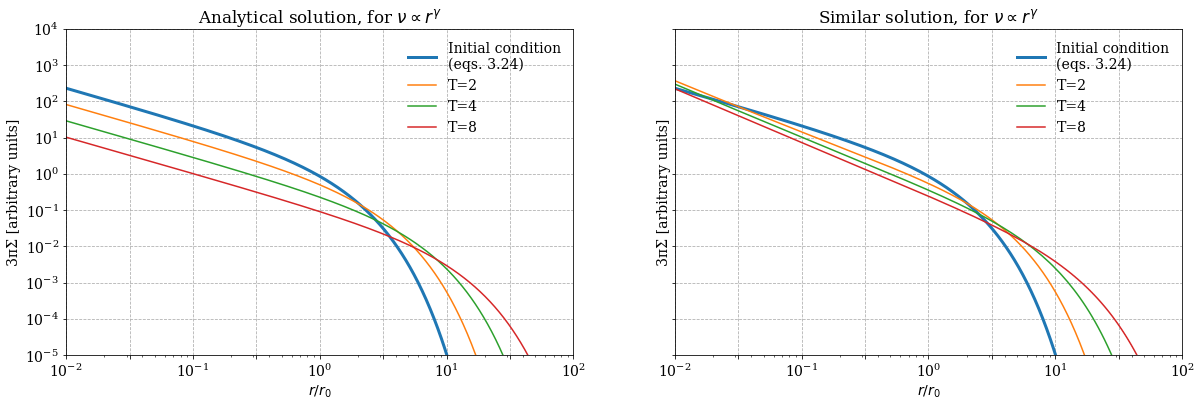

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(20,6), sharey = True) 
### Analytical solution ###
axs[0].grid(ls='--')

axs[0].loglog(r_log, (3 * np.pi) * Σ_initial_norm(r_log), label='Initial condition\n(eqs. 3.24)', lw=3)

for T in Tspan[1:]:
    axs[0].loglog(r_log,  3 * np.pi * Σ(r_log, T), label=f'T={T}')
axs[0].legend(frameon = False)

axs[0].set(title='Analytical solution, for $ν \propto r^γ$', xlabel='$r/r_0$', ylabel='3πΣ [arbitrary units]', 
ylim = (1e-5, 1e4), xlim = (r_log[0], r_log[-1]), yticks = np.logspace(-5, 4, 10), xticks = np.logspace(-2, 2, 9));

### Numerical solution ###
axs[1].grid(ls='--')

axs[1].loglog(r_log, 3 * np.pi * Σ_initial_norm(r_log), label='Initial condition\n(eqs. 3.24)', lw=3)
for τ in tspan[1:]:
    axs[1].loglog(r_log, 3 * np.pi * sol.y[:, sol.t == τ], label=f'T={T_func(τ, t_s):1.0f}')

axs[1].set(title='Similar solution, for $ν \propto r^γ$', ylabel='3πΣ [arbitrary units]', 
xlabel='$r/r_0$', ylim = (1e-5, 1e4), xlim = (r_log[0], r_log[-1]), yticks = np.logspace(-5, 4, 10), xticks = np.logspace(-2, 2, 9))
axs[1].legend(frameon=False)